In [1]:
%load_ext autoreload
%autoreload 2

########################################################
# python
import numpy as np
import warnings

########################################################
# xgboost, sklearn
import xgboost as xgb

warnings.filterwarnings('ignore', message='sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23')
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve

########################################################
# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

########################################################
# set global rnd_seed for reproducability
rnd_seed = 42

In [2]:
from plotting import * # load plotting code

## Generate Random Data

In [3]:
X, y = make_classification(n_samples=int(1e5), n_features=50, n_informative=20, n_redundant=10, n_repeated=2,
                           n_classes=2, n_clusters_per_class=5, weights=[0.7], flip_y=0.2, class_sep=0.9,
                           hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=rnd_seed)

Make Train, Validation, and Holdout Sets

In [4]:
X_trainVal, X_holdout, y_trainVal, y_holdout = train_test_split(X, y, test_size=0.33, random_state=rnd_seed, stratify=y)
del X; del y;

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, test_size=0.2, random_state=rnd_seed, stratify=y_trainVal)
del X_trainVal; del y_trainVal;

#### Set hyperparameters

In [5]:
params_default = {'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.0, 'reg_alpha': 0.0, 'reg_lambda': 1.0}

In [6]:
params_bad = {'max_depth': 2, 'learning_rate': 1.0, 'gamma': 0.0, 'reg_alpha': 0.0, 'reg_lambda': 0.0}

In [7]:
fixed_setup_params = {
'max_num_boost_rounds': 500, # maximum number of boosting rounds to run / trees to create
'xgb_objective': 'binary:logistic', # objective function for binary classification
'xgb_verbosity': 0, #  The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
'xgb_n_jobs': -1, # Number of parallel threads used to run XGBoost. -1 makes use of all cores in your system
}

In [8]:
fixed_fit_params = {
    'early_stopping_rounds': 10, # must see improvement over last num_early_stopping_rounds or will halt
    'eval_set': [(X_val, y_val)], # data sets to use for early stopping evaluation
    'eval_metric': 'auc', # evaluation metric for early stopping
    'verbose': False, # even more verbosity control
}

## Setup XGBClassifiers
#### Run with initial hyperparameters as a baseline

In [9]:
model_default = xgb.XGBClassifier(n_estimators=fixed_setup_params['max_num_boost_rounds'],
                                  objective=fixed_setup_params['xgb_objective'],
                                  verbosity=fixed_setup_params['xgb_verbosity'],
                                  random_state=rnd_seed+3, **params_default)
model_default.fit(X_train, y_train, **fixed_fit_params);

#### Run with bad hyperparameters to compare

In [10]:
model_bad = xgb.XGBClassifier(n_estimators=round(0.25*fixed_setup_params['max_num_boost_rounds']),
                                  objective=fixed_setup_params['xgb_objective'],
                                  verbosity=fixed_setup_params['xgb_verbosity'],
                                  random_state=rnd_seed+4, **params_bad)
model_bad.fit(X_train, y_train, **fixed_fit_params);

## Evaluate

In [11]:
y_holdout_pred_default = model_default.predict_proba(X_holdout, ntree_limit=model_default.best_ntree_limit)[:,1]
fpr_default, tpr_default, thr_default = roc_curve(y_holdout, y_holdout_pred_default)
precision_default, recall_default, thr2_default = precision_recall_curve(y_holdout, y_holdout_pred_default)

y_holdout_pred_bad = model_bad.predict_proba(X_holdout, ntree_limit=model_bad.best_ntree_limit)[:,1]
fpr_bad, tpr_bad, thr_bad = roc_curve(y_holdout, y_holdout_pred_bad)
precision_bad, recall_bad, thr2_bad = precision_recall_curve(y_holdout, y_holdout_pred_bad)

models_for_roc= [
    {'name': 'model_1', 'nname': 'Model 1', 'fpr': fpr_default, 'tpr': tpr_default,
     'pre': precision_default, 'rec':recall_default, 'c': 'C2', 'ls': '-'},
    {'name': 'model_2', 'nname': 'Model 2', 'fpr': fpr_bad, 'tpr': tpr_bad,
     'pre': precision_bad, 'rec':recall_bad, 'c': 'black', 'ls': '--'},
]

In [12]:
pop_PPV = len(np.where(y_holdout == 1)[0]) / len(y_holdout) # P / (P + N)

In [13]:
inline=True

### Standard TPR vs FPR ROC

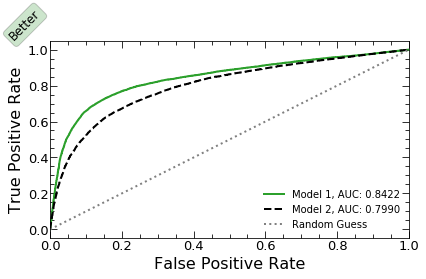

In [18]:
plot_rocs(models_for_roc, rndGuess=True, inverse_log=False, inline=inline)

#### Inverse Log TPR vs FPR ROC

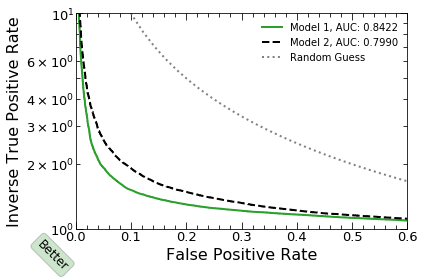

In [15]:
plot_rocs(models_for_roc, rndGuess=True, inverse_log=True,
          x_axis_params={'max': 0.6}, y_axis_params={'min': 1e0, 'max': 1e1}, inline=inline)

### Precision vs Recall ROC

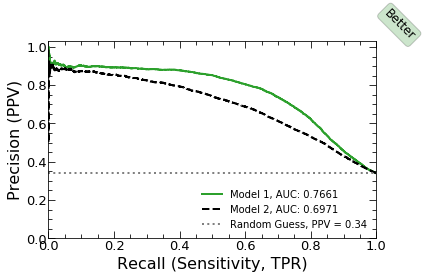

In [16]:
plot_rocs(models_for_roc, rndGuess=True, inverse_log=False, precision_recall=True, pop_PPV=pop_PPV,
          y_axis_params={'min': 0.0}, inline=inline)

#### Inverse Log Precision vs Recall ROC

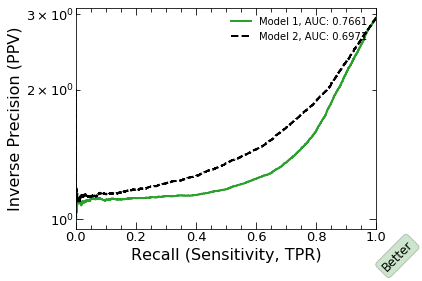

In [17]:
plot_rocs(models_for_roc, rndGuess=False, inverse_log=True, precision_recall=True, pop_PPV=pop_PPV, inline=inline)